In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
import pandas as pd

# ---- Paths (edit) ----
# Use raw strings or forward slashes on Windows to avoid unicode escape errors
REPO_ROOT = Path(r"C:\Users\david\OneDrive\Documents\ml_projects\afm-morphology-transfer-learning")  # or local path
H5_PATH = Path(r"C:\Users\david\OneDrive\Documents\ml_projects\afm-morphology-transfer-learning\datasets\afm_patches_256.h5")     # edit
STATS_PATH = Path(r"C:\Users\david\OneDrive\Documents\ml_projects\afm-morphology-transfer-learning\checkpoints\channel_norm.json")                      # edit
SPLIT_DIR = REPO_ROOT / "splits"
SPLIT_NAME = "val"  # or "val"
CKPT_PATH = REPO_ROOT / "checkpoints/ae_best.pth"  # edit

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [2]:
import sys
sys.path.insert(0, str(REPO_ROOT))

from utils.data import load_channel_norm
from datasets.afm_h5_dataset import AFMPatchesH5Dataset
from model.autoencoder_model import AFMUNetAutoencoder


model = AFMUNetAutoencoder(
    in_channels=1,
    out_channels=1,
    aux_channels=0,     # topo-only for representation learning
).to(DEVICE)


with torch.no_grad():
    y = model(torch.randn(1,1,256,256).to(DEVICE))
print(y.shape)  # should be (1,1,256,256)

b = model.embed_map(torch.randn(1,1,256,256).to(DEVICE))
print(b.shape)  # should be (1, 256, 32, 32)

torch.Size([1, 1, 256, 256])
torch.Size([1, 256, 32, 32])


# Load dataset

In [3]:
import sys
sys.path.insert(0, str(REPO_ROOT))

from utils.data import load_channel_norm
from datasets.afm_h5_dataset import AFMPatchesH5Dataset
from model.autoencoder_model import AFMUNetAutoencoder

norm = load_channel_norm(str(STATS_PATH))

# IMPORTANT: for analysis, we want aux available (phase/friction)
AUX_TYPES = ["PHASE", "FRICTION"]  # adjust to what your H5 actually contains

# Load indices
idx_path = SPLIT_DIR / f"{SPLIT_NAME}.npy"
indices = np.load(idx_path) if idx_path.exists() else None
print("Indices:", None if indices is None else len(indices))

# Create dataset from a .h5 file
ds = AFMPatchesH5Dataset(str(H5_PATH), norm=norm, aux_types=AUX_TYPES, indices=indices)
print("Dataset length:", len(ds))
x0 = ds[0]
print("Sample shape (C,H,W):", x0.shape)


Indices: 27
Dataset length: 27
Sample shape (C,H,W): torch.Size([2, 256, 256])


# Cell 3 — Load topo-only model checkpoint

In [4]:
model = AFMUNetAutoencoder(
    in_channels=1,
    out_channels=1,
    aux_channels=0,     # topo-only for representation learning
).to(DEVICE)

ck = torch.load(CKPT_PATH, map_location=DEVICE)
state = ck["model_state_dict"] if isinstance(ck, dict) and "model_state_dict" in ck else ck
model.load_state_dict(state, strict=True)

model.eval()
for p in model.parameters():
    p.requires_grad = False

print("Loaded checkpoint:", CKPT_PATH)


Loaded checkpoint: C:\Users\david\OneDrive\Documents\ml_projects\afm-morphology-transfer-learning\checkpoints\ae_best.pth


## Helper: encode + downsample aux

In [5]:
@torch.no_grad()
def encode_and_downsample(topo_1chw: torch.Tensor, aux_nchw: torch.Tensor):
    """
    topo_1chw: (1,1,H,W)
    aux_nchw:  (1,A,H,W)  (A can be 1 or 2)
    returns:
      z:      (1,C,h,w)
      aux_ds: (1,A,h,w)
    """
    z = model.embed_map(topo_1chw)  # expects (B,1,H,W)
    h, w = z.shape[-2], z.shape[-1]
    aux_ds = F.adaptive_avg_pool2d(aux_nchw, output_size=(h, w))
    return z, aux_ds


## Cell 5 Main loop: compute per channel spearman correlation
This computes correlation for each latent channel vs each aux channel across all spatial positions and all samples

In [6]:
from scipy.stats import spearmanr
import numpy as np

corr_lists = None
pval_lists = None

N = len(ds)
max_N = N  # or smaller for testing

for i in range(min(N, max_N)):
    x = ds[i].unsqueeze(0).to(DEVICE)  # (1,C,H,W)

    topo = x[:, 0:1]   # (1,1,H,W)
    aux  = x[:, 1:]    # (1,A,H,W)

    z, aux_ds = encode_and_downsample(topo, aux)  # z:(1,C,h,w), aux_ds:(1,A,h,w)
    print("z:", z.shape, "aux_ds:", aux_ds.shape)
    C = z.shape[1]
    A = aux_ds.shape[1]
    hw = z.shape[-2] * z.shape[-1]

    if corr_lists is None:
        corr_lists = [[[] for _ in range(A)] for __ in range(C)]
        pval_lists = [[[] for _ in range(A)] for __ in range(C)]
        print("Latent channels:", C, "Aux channels:", A, "Latent res:", z.shape[-2:], "hw:", hw)

    z_cpu = z.squeeze(0).detach().cpu().numpy()        # (C,h,w)
    aux_cpu = aux_ds.squeeze(0).detach().cpu().numpy() # (A,h,w)

    for k in range(C):
        zk = z_cpu[k].reshape(-1)

        # Guard: Spearman is undefined for constant vectors
        if np.allclose(zk, zk[0]):
            continue

        for a in range(A):
            aa = aux_cpu[a].reshape(-1)
            if np.allclose(aa, aa[0]):
                continue

            r, p = spearmanr(zk, aa)
            if np.isfinite(r):
                corr_lists[k][a].append(float(r))
                pval_lists[k][a].append(float(p))

print("Done. Samples processed:", min(N, max_N))


z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
Latent channels: 256 Aux channels: 1 Latent res: torch.Size([32, 32]) hw: 1024
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size([1, 1, 32, 32])
z: torch.Size([1, 256, 32, 32]) aux_ds: torch.Size

# Cell 6 - Summarize into a table + save CSV

In [7]:
rows = []
C = len(corr_lists)
A = len(corr_lists[0])

aux_names = AUX_TYPES[:A]

for k in range(C):
    row = {"latent_channel": k}
    for a in range(A):
        r = np.array(corr_lists[k][a], dtype=float)
        row[f"{aux_names[a]}_median_r"] = np.nanmedian(r)
        row[f"{aux_names[a]}_median_abs_r"] = np.nanmedian(np.abs(r))
    rows.append(row)

df = pd.DataFrame(rows)

# rank by strongest coupling to any aux channel
df["max_median_abs_r"] = df[[f"{n}_median_abs_r" for n in aux_names]].max(axis=1)
df = df.sort_values("max_median_abs_r", ascending=False).reset_index(drop=True)

out_dir = Path("./latent_aux_results")
out_dir.mkdir(exist_ok=True)
csv_path = out_dir / f"latent_aux_corr_{SPLIT_NAME}.csv"
df.to_csv(csv_path, index=False)

df.head(15), csv_path


(    latent_channel  PHASE_median_r  PHASE_median_abs_r  max_median_abs_r
 0              144       -0.175272            0.175272          0.175272
 1              247        0.172430            0.172430          0.172430
 2              210       -0.164967            0.164967          0.164967
 3               28        0.158516            0.158516          0.158516
 4              196       -0.156491            0.156491          0.156491
 5              229        0.150915            0.150915          0.150915
 6              183        0.147955            0.147955          0.147955
 7               56        0.144412            0.144412          0.144412
 8              138        0.140021            0.140021          0.140021
 9              165        0.137091            0.137091          0.137091
 10              54       -0.125708            0.129922          0.129922
 11              80        0.128438            0.128438          0.128438
 12             220        0.122353   

In [20]:
best

(np.int64(144), np.int64(0))

In [8]:
import numpy as np

C = len(corr_lists)
A = len(corr_lists[0])

median_r = np.full((C, A), np.nan)
mean_abs_r = np.full((C, A), np.nan)
n_eff = np.zeros((C, A), dtype=int)

for k in range(C):
    for a in range(A):
        vals = np.asarray(corr_lists[k][a], dtype=float)
        vals = vals[np.isfinite(vals)]
        n_eff[k, a] = len(vals)
        if len(vals) > 0:
            median_r[k, a] = np.median(vals)
            mean_abs_r[k, a] = np.mean(np.abs(vals))

best = np.unravel_index(np.nanargmax(mean_abs_r), mean_abs_r.shape)
print("Best (k,a):", best, "mean_abs_r:", mean_abs_r[best], "median_r:", median_r[best], "n:", n_eff[best])


Best (k,a): (np.int64(144), np.int64(0)) mean_abs_r: 0.1753683417370474 median_r: -0.17527197674319156 n: 27


In [9]:
import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import spearmanr

# --------- helpers ---------
def _is_constant(v: np.ndarray, eps=1e-12) -> bool:
    return np.nanmax(v) - np.nanmin(v) < eps

def spearman_safe(x: np.ndarray, y: np.ndarray):
    if _is_constant(x) or _is_constant(y):
        return np.nan, np.nan
    r, p = spearmanr(x, y)
    if not np.isfinite(r):
        return np.nan, np.nan
    return float(r), float(p)

def sobel_grad_mag(x_chw: torch.Tensor) -> torch.Tensor:
    device = x_chw.device
    dtype = x_chw.dtype
    x = x_chw.unsqueeze(0)  # (1,C,h,w)

    kx = torch.tensor([[-1,0,1],
                       [-2,0,2],
                       [-1,0,1]], device=device, dtype=dtype).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],
                       [ 0, 0, 0],
                       [ 1, 2, 1]], device=device, dtype=dtype).view(1,1,3,3)

    C = x.shape[1]
    kx = kx.repeat(C, 1, 1, 1)
    ky = ky.repeat(C, 1, 1, 1)

    # reflect pad manually, then no padding in conv
    xpad = F.pad(x, (1,1,1,1), mode="reflect")
    gx = F.conv2d(xpad, kx, padding=0, groups=C)
    gy = F.conv2d(xpad, ky, padding=0, groups=C)

    return torch.sqrt(gx*gx + gy*gy + 1e-12).squeeze(0)


def lowpass_avg(x: torch.Tensor, k: int = 3) -> torch.Tensor:
    """
    x: (C,h,w) or (A,h,w)
    simple low-pass via avg pooling (same size, uses padding)
    """
    x1 = x.unsqueeze(0)  # (1,C,h,w)
    pad = k // 2
    # pad then pool with stride 1 to keep size
    x1 = F.pad(x1, (pad, pad, pad, pad), mode="reflect")
    y = F.avg_pool2d(x1, kernel_size=k, stride=1)
    return y.squeeze(0)
    
def flatten_center(x, margin=3):
    return x[..., margin:-margin, margin:-margin].reshape(-1)
# --------- main correlation pass ---------
# corr_A[k][a] list = raw intensity spearman per sample
# corr_B[k][a] list = gradient magnitude spearman per sample
# corr_C[k][a] list = spearman between z and low-passed aux per sample
corrA = pvalA = None
corrB = pvalB = None
corrC = pvalC = None

N = len(ds)
max_N = N  # set smaller to test

for i in range(min(N, max_N)):
    x = ds[i].unsqueeze(0).to(DEVICE)   # (1,C,H,W)
    topo = x[:, 0:1]
    aux  = x[:, 1:]

    z, aux_ds = encode_and_downsample(topo, aux)  # z:(1,C,h,w), aux_ds:(1,A,h,w)
    C = z.shape[1]
    A = aux_ds.shape[1]
    h, w = z.shape[-2:]
    margin = 3
    assert h > 2*margin and w > 2*margin, f"margin too big for grid {(h,w)}"
    
    if corrA is None:
        corrA = [[[] for _ in range(A)] for __ in range(C)]
        pvalA = [[[] for _ in range(A)] for __ in range(C)]
        corrB = [[[] for _ in range(A)] for __ in range(C)]
        pvalB = [[[] for _ in range(A)] for __ in range(C)]
        corrC = [[[] for _ in range(A)] for __ in range(C)]
        pvalC = [[[] for _ in range(A)] for __ in range(C)]
        print("Latent:", C, "Aux:", A, "Grid:", (h, w), "points:", h*w)

    # tensors on CPU for numpy correlation
    z_chw   = z.squeeze(0).detach().cpu()        # (C,h,w)
    aux_ahw = aux_ds.squeeze(0).detach().cpu()   # (A,h,w)

    # B) gradient magnitude maps
    z_grad   = sobel_grad_mag(z_chw)            # (C,h,w)
    aux_grad = sobel_grad_mag(aux_ahw)          # (A,h,w)

    # C) low-pass aux (match bottleneck bandwidth)
    aux_lp = lowpass_avg(aux_ahw, k=3)          # (A,h,w)  (try k=5 too)

    # Loop channels
    z_np      = z_chw.numpy()
    zgrad_np  = z_grad.numpy()
    aux_np    = aux_ahw.numpy()
    auxgrad_np= aux_grad.numpy()
    auxlp_np  = aux_lp.numpy()

    for k in range(C):
        zk  = flatten_center(z_np[k], margin=margin)
        zgk = flatten_center(zgrad_np[k], margin=margin)

        for a in range(A):
            aa  = flatten_center(aux_np[a], margin=margin)
            ag  = flatten_center(auxgrad_np[a], margin=margin)
            alp = flatten_center(auxlp_np[a], margin=margin)


            # A) raw intensity
            r, p = spearman_safe(zk, aa)
            if np.isfinite(r):
                corrA[k][a].append(r); pvalA[k][a].append(p)

            # B) gradient magnitude
            r, p = spearman_safe(zgk, ag)
            if np.isfinite(r):
                corrB[k][a].append(r); pvalB[k][a].append(p)

            # C) low-pass aux
            r, p = spearman_safe(zk, alp)
            if np.isfinite(r):
                corrC[k][a].append(r); pvalC[k][a].append(p)

print("Done. Samples processed:", min(N, max_N))


Latent: 256 Aux: 1 Grid: (32, 32) points: 1024
Done. Samples processed: 27


In [12]:
import numpy as np

def summarize(corr_lists):
    C = len(corr_lists)
    A = len(corr_lists[0])
    med = np.full((C,A), np.nan)
    mean_abs = np.full((C,A), np.nan)
    n = np.zeros((C,A), dtype=int)

    for k in range(C):
        for a in range(A):
            v = np.asarray(corr_lists[k][a], dtype=float)
            v = v[np.isfinite(v)]
            n[k,a] = len(v)
            if len(v) > 0:
                med[k,a] = np.median(v)
                mean_abs[k,a] = np.mean(np.abs(v))
    return med, mean_abs, n

medA, absA, nA = summarize(corrA)
medB, absB, nB = summarize(corrB)
medC, absC, nC = summarize(corrC)

def top_pairs(absM, nM, top=10, min_n=20):
    M = absM.copy()
    M[nM < min_n] = np.nan
    idx = np.dstack(np.unravel_index(np.argsort(-np.nan_to_num(M, nan=-1).ravel()), M.shape))[0]
    out = []
    for k,a in idx:
        if len(out) >= top: break
        if np.isfinite(M[k,a]):
            out.append((int(k), int(a), float(M[k,a]), int(nM[k,a])))
    return out

print("Top |r| RAW (A):", top_pairs(absA, nA, top=10))
print("Top |r| GRAD (B):", top_pairs(absB, nB, top=10))
print("Top |r| LP-AUX (C):", top_pairs(absC, nC, top=10))


Top |r| RAW (A): [(144, 0, 0.19044491327950316, 27), (247, 0, 0.18686142900236777, 27), (210, 0, 0.17716597614892904, 27), (28, 0, 0.1769878648393623, 27), (183, 0, 0.17385205475648957, 27), (229, 0, 0.17186989348637643, 27), (196, 0, 0.1711864756441393, 27), (56, 0, 0.15880524689333286, 27), (165, 0, 0.15665127817026037, 27), (138, 0, 0.15261866103702987, 27)]
Top |r| GRAD (B): [(56, 0, 0.10172770303412022, 27), (88, 0, 0.09731439267991276, 27), (196, 0, 0.09604603407933837, 27), (206, 0, 0.09382363849053238, 27), (7, 0, 0.09357205839979262, 27), (247, 0, 0.09300113207950769, 27), (194, 0, 0.09283005086007269, 27), (144, 0, 0.09226593470000154, 27), (99, 0, 0.09210891349183717, 27), (146, 0, 0.08963827278109747, 27)]
Top |r| LP-AUX (C): [(247, 0, 0.4733410896288061, 27), (210, 0, 0.4676706227586482, 27), (144, 0, 0.45674910913583033, 27), (28, 0, 0.4510567260847606, 27), (229, 0, 0.44668717227632765, 27), (138, 0, 0.4301532043783298, 27), (56, 0, 0.4261642768639322, 27), (196, 0, 0.41

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_maps_with_mask(z_map, aux_map, z_grad=None, aux_grad=None, margin=3):
    """
    z_map, aux_map: (h,w) numpy arrays
    z_grad, aux_grad: optional (h,w)
    """
    h, w = z_map.shape

    def add_rect(ax):
        rect = patches.Rectangle(
            (margin, margin),
            w - 2*margin,
            h - 2*margin,
            linewidth=1.5,
            edgecolor='white',
            facecolor='none'
        )
        ax.add_patch(rect)

    ncols = 2 if z_grad is None else 4
    fig, axs = plt.subplots(1, ncols, figsize=(3*ncols, 3))

    axs[0].imshow(z_map, cmap='viridis')
    axs[0].set_title("Latent z")
    #add_rect(axs[0])
    axs[0].axis("off")

    axs[1].imshow(aux_map, cmap='viridis')
    axs[1].set_title("Aux ds")
    #add_rect(axs[1])
    axs[1].axis("off")

    if z_grad is not None:
        axs[2].imshow(z_grad, cmap='magma')
        axs[2].set_title("|∇z|")
        #add_rect(axs[2])
        axs[2].axis("off")

        axs[3].imshow(aux_grad, cmap='magma')
        axs[3].set_title("|∇aux|")
        #add_rect(axs[3])
        axs[3].axis("off")

    plt.tight_layout()
    plt.show()


In [22]:
best

(np.int64(144), np.int64(0))

In [21]:
k,a

(255, 0)

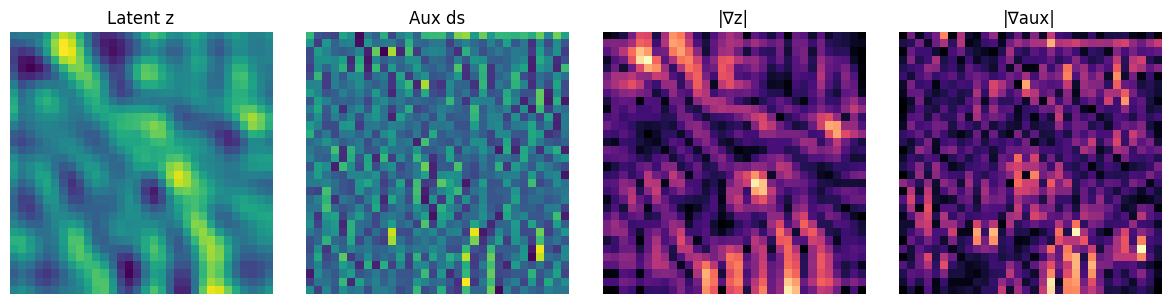

In [23]:
k,a = best
z_ch_t   = z[0, k].detach().cpu()       # (h,w) torch
aux_ch_t = aux_ds[0, a].detach().cpu()  # (h,w) torch

z_grad = sobel_grad_mag(z_ch_t.unsqueeze(0))[0].numpy()
aux_grad = sobel_grad_mag(aux_ch_t.unsqueeze(0))[0].numpy()

show_maps_with_mask(z_ch_t.numpy(), aux_ch_t.numpy(), z_grad, aux_grad, margin=3)


# Cell 7

Top channels: [144 247 210  28 196]


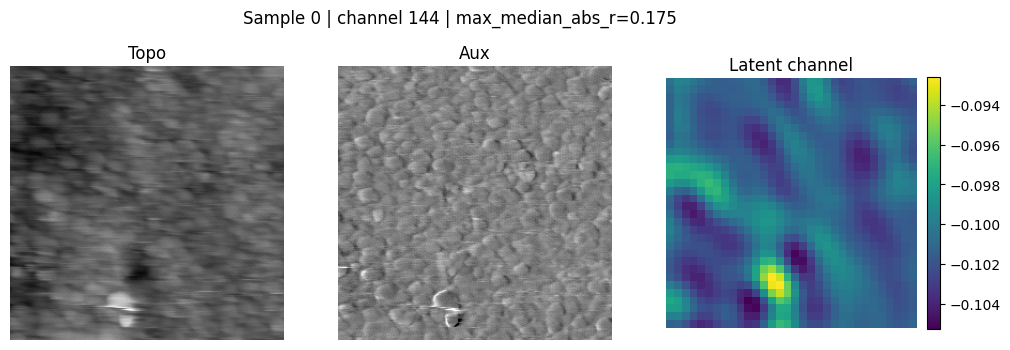

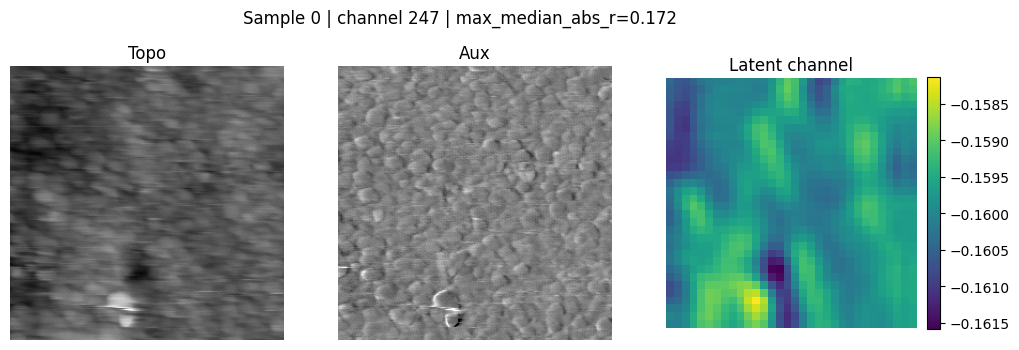

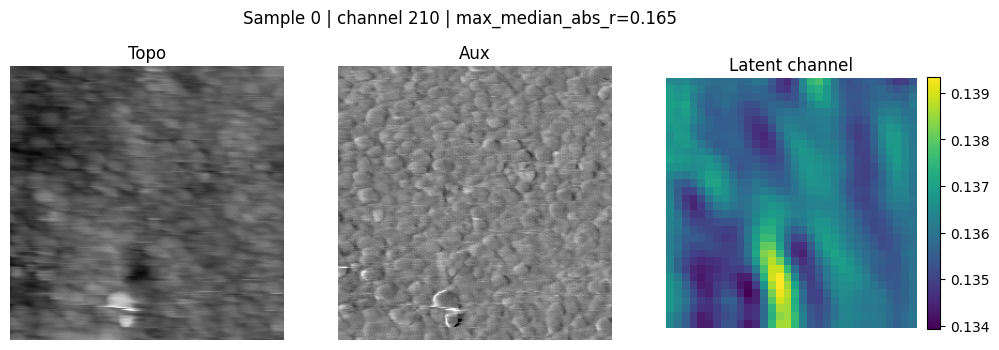

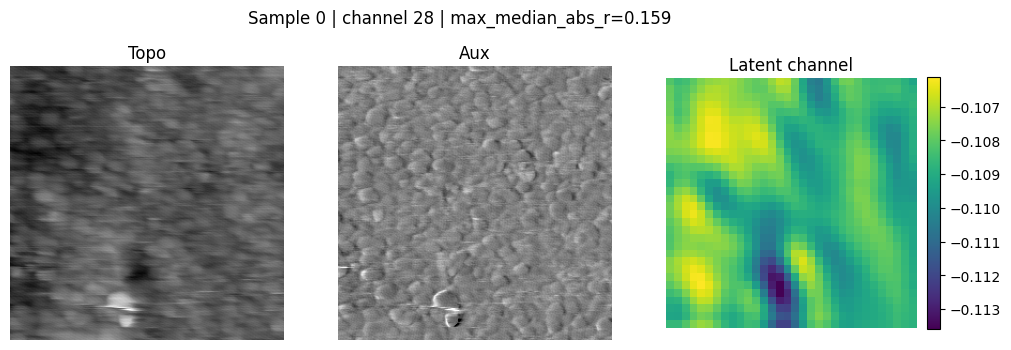

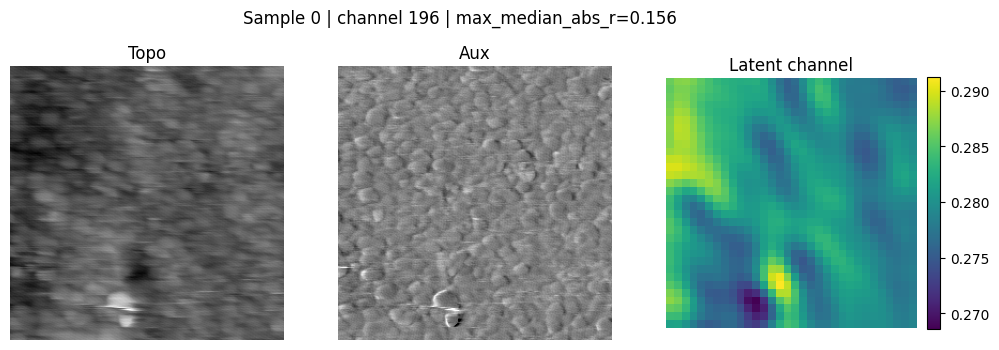

In [24]:
def show_triplet(topo_hw, aux_hw, z_hw, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(topo_hw, cmap="gray"); axes[0].set_title("Topo"); axes[0].axis("off")
    axes[1].imshow(aux_hw, cmap="gray");  axes[1].set_title("Aux");  axes[1].axis("off")
    im = axes[2].imshow(z_hw);            axes[2].set_title("Latent channel"); axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    fig.suptitle(title)
    plt.show()

top_k = 5
top_channels = df["latent_channel"].values[:top_k]
print("Top channels:", top_channels)

# pick one representative sample to visualize
i = 0
x = ds[i].unsqueeze(0).to(DEVICE)
topo = x[:, 0:1]
aux  = x[:, 1:]

with torch.no_grad():
    z, aux_ds = encode_and_downsample(topo, aux)

topo_np = topo.squeeze().detach().cpu().numpy()
aux_np  = aux[:, 0:1].squeeze().detach().cpu().numpy()  # show first aux (e.g. PHASE)
z_np    = z.squeeze(0).detach().cpu().numpy()           # (C,h,w)

for k in top_channels:
    show_triplet(topo_np, aux_np, z_np[k], title=f"Sample {i} | channel {k} | max_median_abs_r={df.loc[df.latent_channel==k,'max_median_abs_r'].values[0]:.3f}")


# Table per metric

In [25]:
import numpy as np

def summarize_corr(corr_lists):
    C = len(corr_lists)
    A = len(corr_lists[0])
    mean_abs = np.full((C,A), np.nan)
    med_abs  = np.full((C,A), np.nan)
    iqr      = np.full((C,A), np.nan)
    frac_pos = np.full((C,A), np.nan)
    n_eff    = np.zeros((C,A), dtype=int)

    for k in range(C):
        for a in range(A):
            r = np.asarray(corr_lists[k][a], dtype=float)
            r = r[np.isfinite(r)]
            n_eff[k,a] = len(r)
            if len(r) == 0:
                continue
            mean_abs[k,a] = np.mean(np.abs(r))
            med_abs[k,a]  = np.median(np.abs(r))
            iqr[k,a]      = np.percentile(r, 75) - np.percentile(r, 25)
            frac_pos[k,a] = np.mean(r > 0)
    return mean_abs, med_abs, iqr, frac_pos, n_eff

def top_k(mat, n_eff, top=10, min_n=10):
    M = mat.copy()
    M[n_eff < min_n] = np.nan
    flat = np.argsort(-np.nan_to_num(M, nan=-1).ravel())
    out = []
    C, A = M.shape
    for idx in flat:
        k = idx // A
        a = idx % A
        if np.isfinite(M[k,a]):
            out.append((int(k), int(a), float(M[k,a]), int(n_eff[k,a])))
        if len(out) >= top:
            break
    return out


In [26]:
meanA, medA, iqrA, fracA, nA = summarize_corr(corrA)
meanB, medB, iqrB, fracB, nB = summarize_corr(corrB)
meanC, medC, iqrC, fracC, nC = summarize_corr(corrC)

print("Top-10 by median |r| (A raw):", top_k(medA, nA))
print("Top-10 by median |r| (B grad):", top_k(medB, nB))
print("Top-10 by median |r| (C low-pass):", top_k(medC, nC))


Top-10 by median |r| (A raw): [(144, 0, 0.19719946354192458, 27), (247, 0, 0.19112214326849025, 27), (210, 0, 0.1769809003539895, 27), (196, 0, 0.17236763110641076, 27), (28, 0, 0.17151015278955284, 27), (183, 0, 0.1701236747572391, 27), (229, 0, 0.16830628221152025, 27), (165, 0, 0.16108321024126046, 27), (56, 0, 0.1581727406656392, 27), (138, 0, 0.15286479683252777, 27)]
Top-10 by median |r| (B grad): [(88, 0, 0.10183613555957606, 27), (56, 0, 0.10059719320939636, 27), (206, 0, 0.10025461364627368, 27), (4, 0, 0.0988448670848398, 27), (99, 0, 0.09614055123883553, 27), (146, 0, 0.09464087705651163, 27), (7, 0, 0.0943675980876299, 27), (144, 0, 0.0941133146291651, 27), (26, 0, 0.09376599589984433, 27), (168, 0, 0.09250592152989608, 27)]
Top-10 by median |r| (C low-pass): [(247, 0, 0.49935627943126665, 27), (210, 0, 0.49759316877931675, 27), (144, 0, 0.47857964858305724, 27), (229, 0, 0.46655071247731167, 27), (28, 0, 0.4639379214282946, 27), (138, 0, 0.4451280109000822, 27), (56, 0, 0.

In [27]:
import matplotlib.pyplot as plt

def show_channel_across_samples(k, a=0, idxs=None, margin=4, lp_k=5):
    if idxs is None:
        idxs = list(range(6))
    n = len(idxs)
    fig, axs = plt.subplots(n, 4, figsize=(12, 3*n))

    for row, i in enumerate(idxs):
        x = ds[i].unsqueeze(0).to(DEVICE)
        topo, aux = x[:,0:1], x[:,1:]
        z, aux_ds = encode_and_downsample(topo, aux)

        z_ch = z[0,k].detach().cpu()
        aux_ch = aux_ds[0,a].detach().cpu()
        aux_lp = lowpass_avg(aux_ch.unsqueeze(0), k=lp_k)[0]

        z_g  = sobel_grad_mag(z_ch.unsqueeze(0))[0]
        aux_g = sobel_grad_mag(aux_lp.unsqueeze(0))[0]  # compare vs low-passed aux

        axs[row,0].imshow(z_ch, cmap="viridis"); axs[row,0].set_title(f"z k={k} (i={i})")
        axs[row,1].imshow(aux_lp, cmap="viridis"); axs[row,1].set_title(f"aux_lp k={lp_k}")
        axs[row,2].imshow(z_g, cmap="magma"); axs[row,2].set_title("|∇z|")
        axs[row,3].imshow(aux_g, cmap="magma"); axs[row,3].set_title("|∇aux_lp|")

        for c in range(4):
            axs[row,c].axis("off")
            # mask box
            h,w = z_ch.shape
            axs[row,c].add_patch(
                plt.Rectangle((margin,margin), w-2*margin, h-2*margin,
                              fill=False, edgecolor="white", linewidth=1)
            )

    plt.tight_layout()
    plt.show()


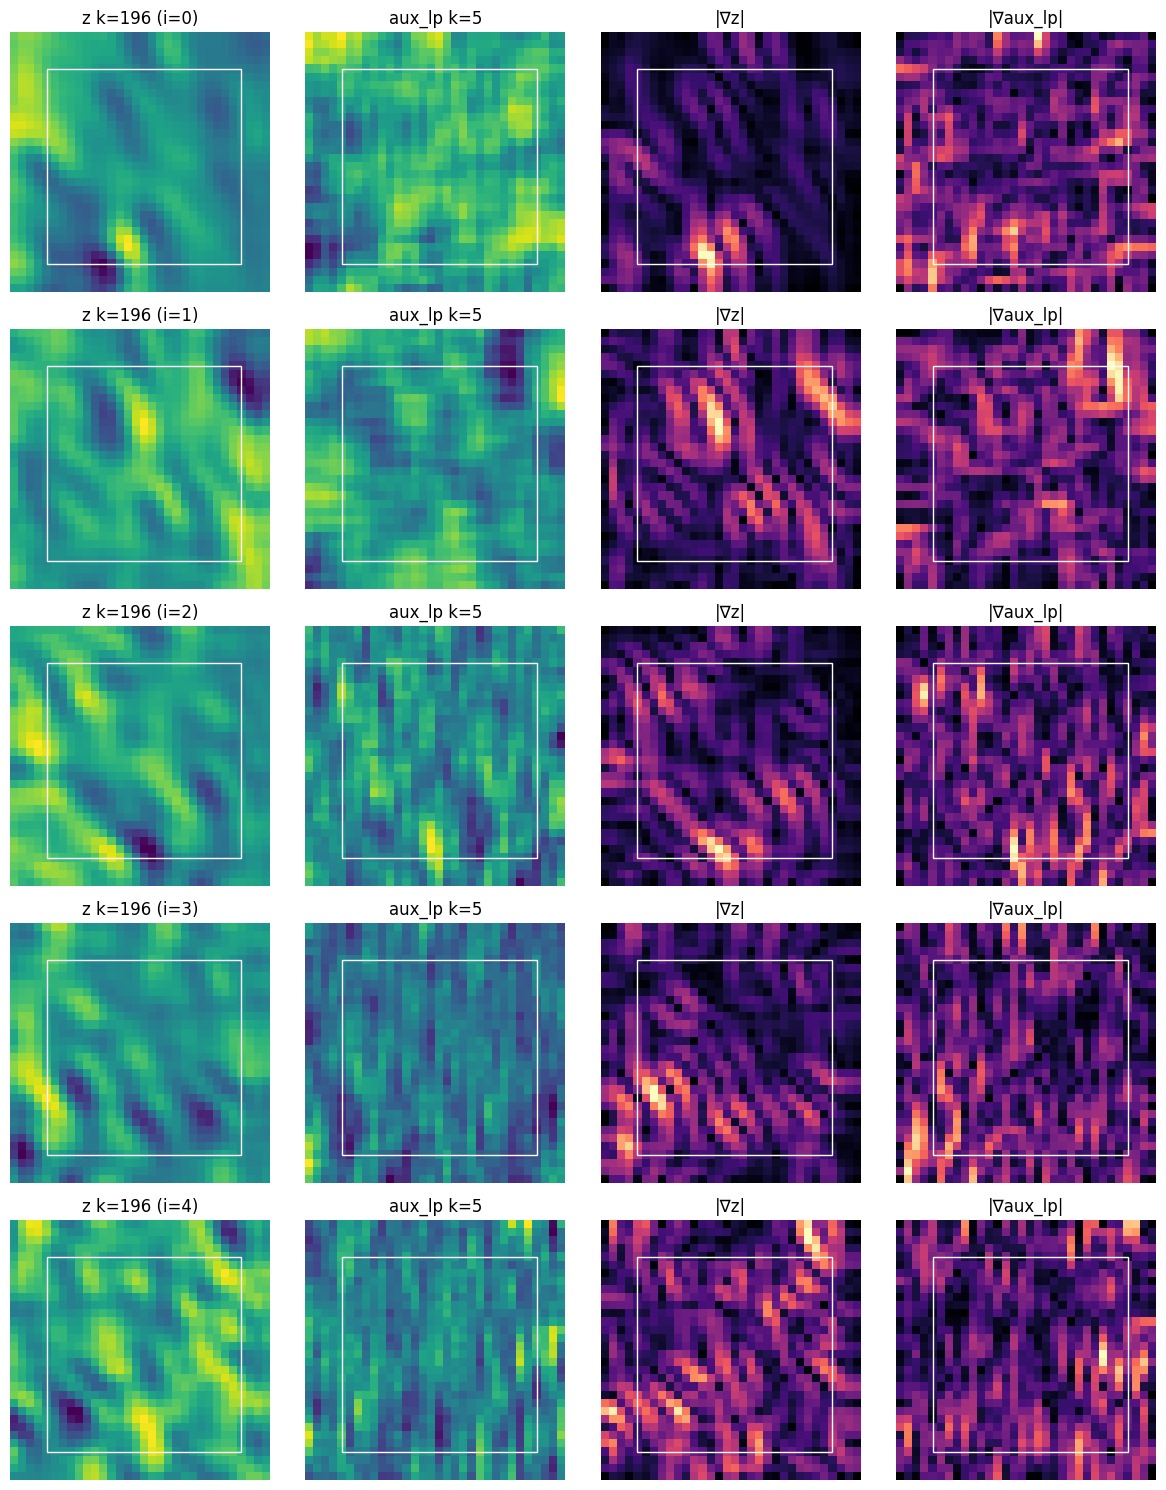

In [28]:
show_channel_across_samples(k, a=0, idxs=[0,1,2,3,4], margin=4, lp_k=5)